In [1]:
import os, time, itertools, pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
# G(z)
def generator(x):
    # initializers
    w_init = tf.truncated_normal_initializer(mean=0, stddev=0.02)
    b_init = tf.constant_initializer(0.)
    #1st hidden layer
    w0 = tf.get_variable('G_w0', [x.get_shape()[1], 256], initializer=w_init)
    b0 = tf.get_variable('G_b0', [256], initializer=b_init)
    h0 = tf.nn.leaky_relu(tf.matmul(x, w0) + b0)
    #2nd hidden layer
    w1 = tf.get_variable('G_w1', [h0.get_shape()[1], 512], initializer=w_init)
    b1 = tf.get_variable('G_b1', [512], initializer=b_init)
    h1 = tf.nn.leaky_relu(tf.matmul(h0, w1) + b1)
    #3rd hidden layer
    w2 = tf.get_variable('G_w2', [h1.get_shape()[1], 1024], initializer=w_init)
    b2 = tf.get_variable('G_b2', [1024], initializer=b_init)
    h2 = tf.nn.leaky_relu(tf.matmul(h1, w2) + b2)
    
    # output hidden layer
    w3 = tf.get_variable('G_w3', [h2.get_shape()[1], 784], initializer=w_init)
    b3 = tf.get_variable('G_b3', [784], initializer=b_init)
    o = tf.nn.tanh(tf.matmul(h2, w3) + b3)

    return o

In [2]:
# D(x)
def discriminator(x, drop_out):
    # initializers
    w_init = tf.truncated_normal_initializer(mean=0, stddev=0.02)
    b_init = tf.constant_initializer(0.)

    #1st hidden layer
    w0 = tf.get_variable('D_w0', [x.get_shape()[1], 784], initializer=w_init)
    b0 = tf.get_variable('D_b0', [784], initializer=b_init)
    h0 = tf.nn.relu(tf.matmul(x, w0) + b0)
    #2nd hidden layer
    w1 = tf.get_variable('D_w1', [h0.get_shape()[1], 1024], initializer=w_init)
    b1 = tf.get_variable('D_b1', [1024], initializer=b_init)
    h1 = tf.nn.leaky_relu(tf.matmul(h0, w1) + b1)
    h1 = tf.nn.dropout(h1, 0.3)
    #3rd hidden layer
    w2 = tf.get_variable('D_w2', [h1.get_shape()[1], 512], initializer=w_init)
    b2 = tf.get_variable('D_b2', [512], initializer=b_init)
    h2 = tf.nn.leaky_relu(tf.matmul(h1, w2) + b2)
    h2 = tf.nn.dropout(h2, 0.3)
    #4th hidden layer
    w3 = tf.get_variable('D_w3', [h2.get_shape()[1], 256], initializer=w_init)
    b3 = tf.get_variable('D_b3', [256], initializer=b_init)
    h3 = tf.nn.leaky_relu(tf.matmul(h2, w3) + b3)
    h3 = tf.nn.dropout(h3, 0.3)
    # output layer
    w4 = tf.get_variable('D_w4', [h3.get_shape()[1], 1], initializer=w_init)
    b4 = tf.get_variable('D_b4', [1], initializer=b_init)
    o4 = tf.sigmoid(tf.matmul(h3, w4) + b4)
    return o4

In [3]:
fixed_z_ = np.random.normal(0, 1, (25, 100))
def show_result(num_epoch, show = True, save = True, path = 'result.png',isFix=False):
    z_ = np.random.normal(0, 1, (25, 100))    # z_ is the input of generator, every epochs will random produce input

    if isFix:
        test_images = sess.run(G_z, {z: fixed_z_, drop_out: 0.0})
    else:
        test_images = sess.run(G_z, {z: z_, drop_out: 0.0})

    size_figure_grid = 5
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(5*5):
        i = k // 5
        j = k % 5
        ax[i, j].cla()
        ax[i, j].imshow(np.reshape(test_images[k], (28, 28)), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')
    plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

In [4]:
def show_train_hist(hist, show = True, save = True, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

In [5]:
# training parameters
batch_size = 100
lr = 0.0002
train_epoch = 10

# load MNIST
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
train_set = (mnist.train.images - 0.5) / 0.5  # normalization; range: -1 ~ 1

# networks : generator
with tf.variable_scope('G'):
    z = tf.placeholder(tf.float32, shape=(None, 100))
    G_z = generator(z)
# networks : discriminator
with tf.variable_scope('D') as scope:
    drop_out = tf.placeholder(dtype=tf.float32, name='drop_out')
    x = tf.placeholder(tf.float32, shape=(None, 784))
    D_real = discriminator(x, drop_out)
    scope.reuse_variables()
    D_fake = discriminator(G_z, drop_out)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


[1/10] - ptime: 39.33 loss_d: 0.777, loss_g: 2.226


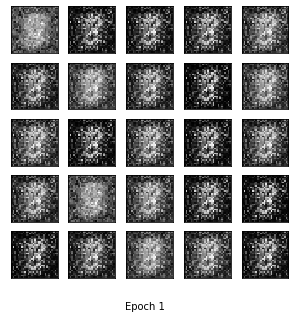

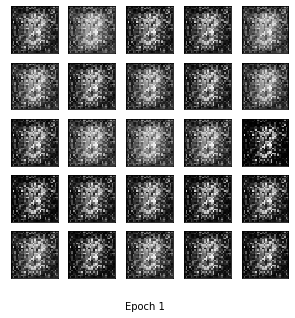

[2/10] - ptime: 42.71 loss_d: 0.056, loss_g: 4.493


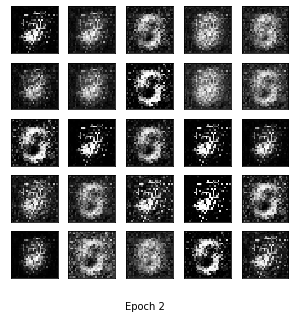

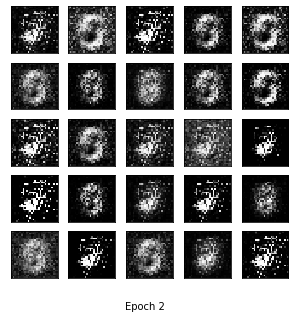

[3/10] - ptime: 45.29 loss_d: 0.223, loss_g: 4.247


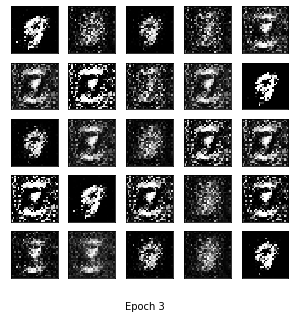

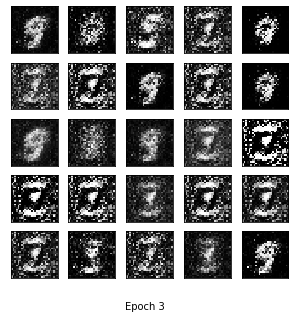

[4/10] - ptime: 39.49 loss_d: 0.183, loss_g: 4.168


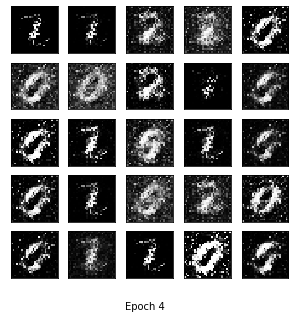

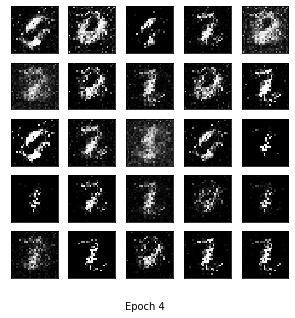

[5/10] - ptime: 38.18 loss_d: 0.292, loss_g: 3.820


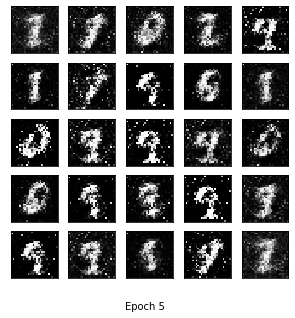

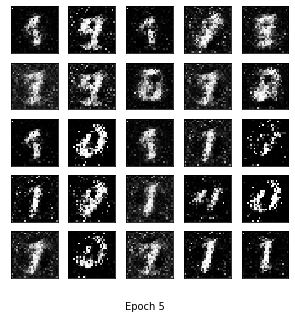

[6/10] - ptime: 38.29 loss_d: 0.291, loss_g: 3.757


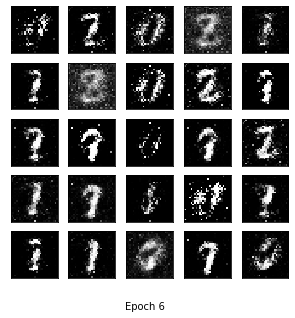

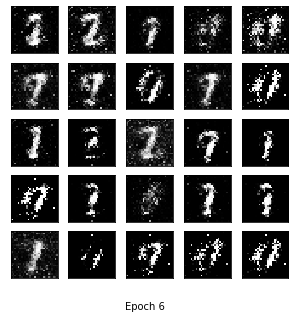

[7/10] - ptime: 37.82 loss_d: 0.278, loss_g: 3.719


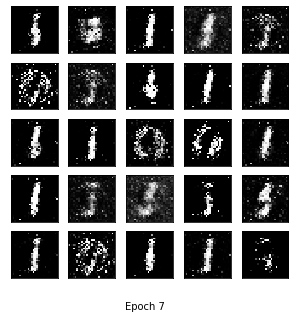

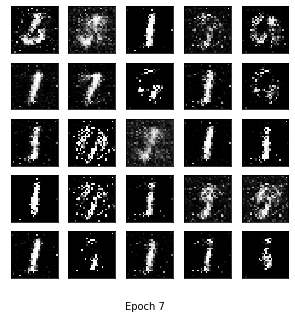

[8/10] - ptime: 38.76 loss_d: 0.314, loss_g: 3.546


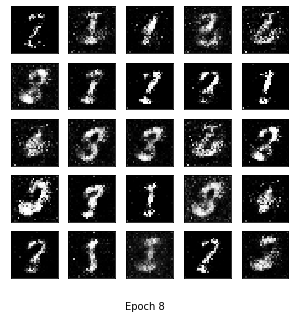

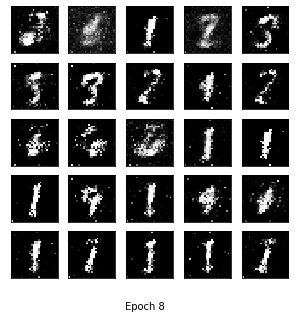

[9/10] - ptime: 40.04 loss_d: 0.334, loss_g: 3.458


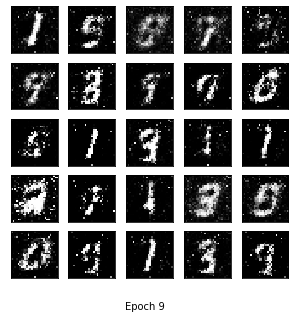

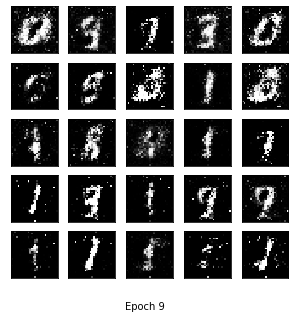

[10/10] - ptime: 42.47 loss_d: 0.378, loss_g: 3.198


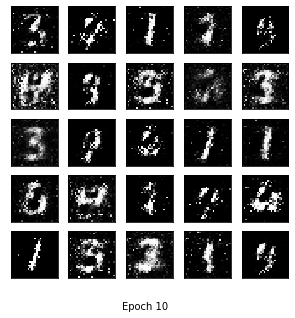

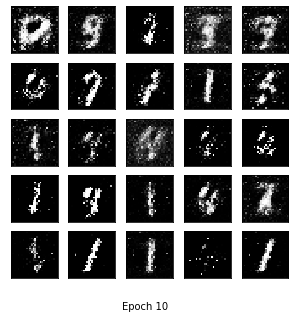

Avg per epoch ptime: 40.24, total 10 epochs ptime: 424.65
Training finish!... save training results


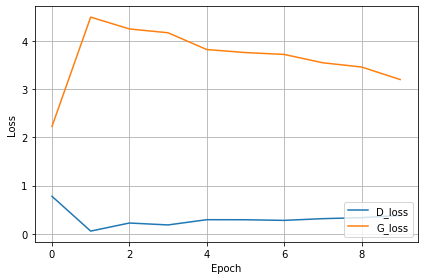

In [6]:

# loss for each network
eps = 1e-2
D_loss = tf.reduce_mean(-tf.log(D_real + eps) - tf.log(1 - D_fake + eps))
G_loss = tf.reduce_mean(-tf.log(D_fake + eps))

# trainable variables for each network
t_vars = tf.trainable_variables()
D_vars = [var for var in t_vars if 'D_' in var.name]
G_vars = [var for var in t_vars if 'G_' in var.name]

# optimizer for each network
D_optim = tf.train.AdamOptimizer(lr).minimize(D_loss, var_list=D_vars)
G_optim = tf.train.AdamOptimizer(lr).minimize(G_loss, var_list=G_vars)

# open session and initialize all variables
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

# results save folder
if not os.path.isdir('MNIST_GAN_results'):
    os.mkdir('MNIST_GAN_results')
if not os.path.isdir('MNIST_GAN_results/results'):
    os.mkdir('MNIST_GAN_results/results')
train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []
# training-loop
np.random.seed(int(time.time()))
start_time = time.time()
for epoch in range(train_epoch):
    G_losses = []
    D_losses = []
    epoch_start_time = time.time()
    for iter in range(train_set.shape[0] // batch_size):
        # update discriminator
        x_ = train_set[iter*batch_size:(iter+1)*batch_size]
        z_ = np.random.normal(0, 1, (batch_size, 100))

        loss_d_, _ = sess.run([D_loss, D_optim], {x: x_, z: z_, drop_out: 0.3})
        D_losses.append(loss_d_)

        # update generator
        z_ = np.random.normal(0, 1, (batch_size, 100))
        loss_g_, _ = sess.run([G_loss, G_optim], {z: z_, drop_out: 0.3})
        G_losses.append(loss_g_)

    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time
    print('[%d/%d] - ptime: %.2f loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), train_epoch, per_epoch_ptime, np.mean(D_losses), np.mean(G_losses)))
    
    p = 'C:/Users/Hasan/Desktop/Deep_Learning/CW2/MNIST_GAN_' + str(epoch + 1) + '.png'
    fixed_p = 'C:/Users/Hasan/Desktop/Deep_Learning/CW2/MNIST_GAN_' + str(epoch + 1) + '.png'
    show_result((epoch + 1), save=True, path=p, isFix=False)
    show_result((epoch + 1), save=True, path=fixed_p, isFix=True)
    

    train_hist['D_losses'].append(np.mean(D_losses))
    train_hist['G_losses'].append(np.mean(G_losses))
    train_hist['per_epoch_ptimes'].append(per_epoch_ptime)
end_time = time.time()
total_ptime = end_time - start_time
train_hist['total_ptime'].append(total_ptime)
print('Avg per epoch ptime: %.2f, total %d epochs ptime: %.2f' % (np.mean(train_hist['per_epoch_ptimes']), train_epoch, total_ptime))
print("Training finish!... save training results")
with open('MNIST_GAN_results/train_hist.pkl', 'wb') as f:
    pickle.dump(train_hist, f)
show_train_hist(train_hist, save=True, path='C:/Users/Hasan/Desktop/Deep_Learning/CW2/MNIST_GAN_train_hist.png')
images = []
sess.close()